# Open Linux env and getting the necessary data

You just need to download this ~28 MB file only once

In [1]:
!rm -f SRR003265.filt.fastq.gz 2>/dev/null
!wget -nd ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/phase3/data/NA18489/sequence_read/SRR003265.filt.fastq.gz

The system cannot find the path specified.
'wget' is not recognized as an internal or external command,
operable program or batch file.


### 1. Open the file

In [7]:
from collections import defaultdict
import gzip

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

from Bio import SeqIO

dataset_path = '../datasets/SRR003265.filt.fastq.gz'

In [3]:
recs = SeqIO.parse(gzip.open(dataset_path, 'rt', encoding='utf-8'), 'fastq')
rec = next(recs)
print(rec.id, rec.description, rec.seq)
print(rec.letter_annotations)

SRR003265.31 SRR003265.31 3042NAAXX:3:1:1252:1819 length=51 GGGAAAAGAAAAACAAACAAACAAAAACAAAACACAGAAACAAAAAAACCA
{'phred_quality': [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 30, 23, 40, 32, 35, 29, 40, 16, 40, 40, 32, 35, 31, 40, 40, 39, 22, 40, 24, 20, 28, 31, 12, 31, 10, 22, 28, 13, 26, 20, 23, 23]}


### 2. Get distribution of nucleotide reads
We will reopen the file again and use defaultdict to maintain a count of nucleotide references in the FASTQ file. If you have never used this Python standard dictionary type, you may want to consider it because it removes the need to initialize dictionary entries, assuming default values for each type.

In [4]:
recs = SeqIO.parse(gzip.open(dataset_path, 'rt', encoding='utf-8'), 'fastq')
cnt = defaultdict(int)
for rec in recs:
    for letter in rec.seq:
        cnt[letter] += 1
tot = sum(cnt.values())
for letter, cnt in cnt.items():
    print('%s: %.2f %d' % (letter, 100. * cnt / tot, cnt))

G: 20.68 5359334
A: 28.60 7411965
C: 21.00 5444053
T: 29.58 7666885
N: 0.14 37289


### 3. Plot the distribution of Ns according to its read position

(1.0, 51.0)

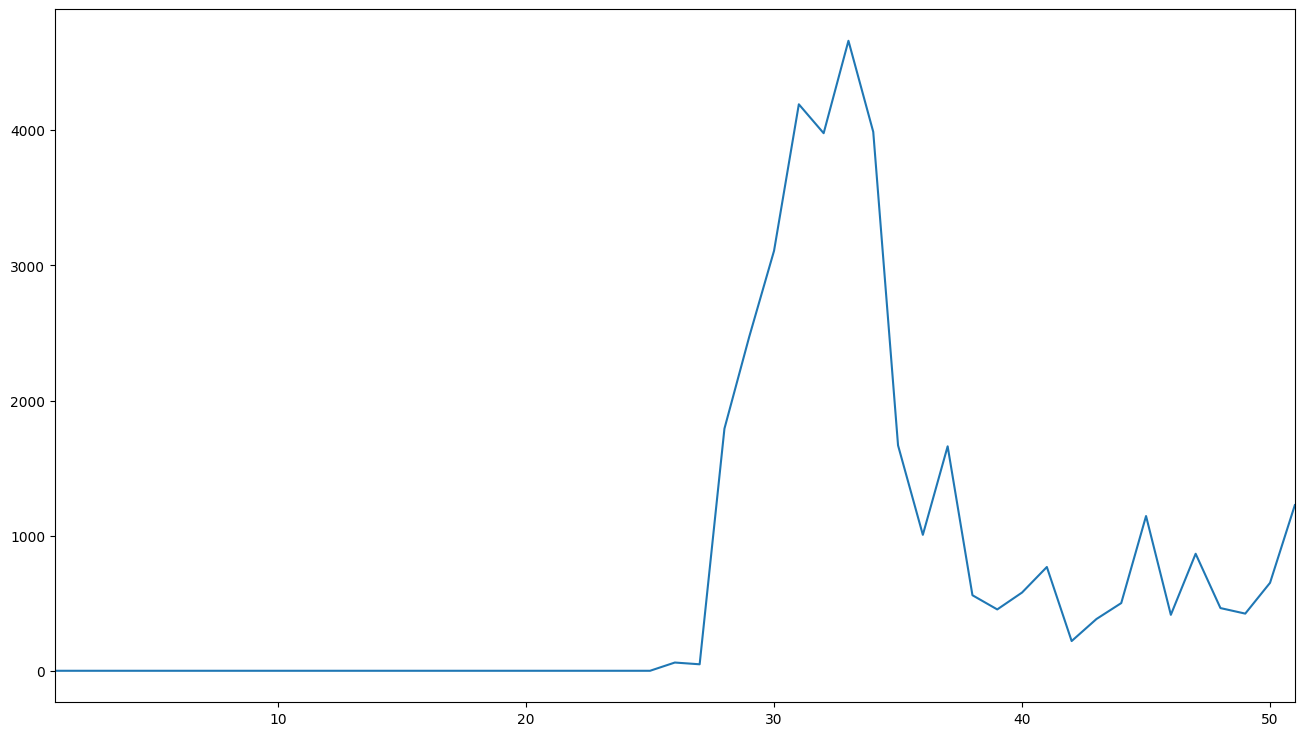

In [6]:
recs = SeqIO.parse(gzip.open(dataset_path, 'rt', encoding='UTF-8'), 'fastq')
n_cnt = defaultdict(int)
for rec in recs:
    for i, letter in enumerate(rec.seq):
        pos = i + 1
        if letter == 'N':
            n_cnt[pos] += 1
seq_len = max(n_cnt.keys())
positions = range(1, seq_len + 1)
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(positions, [n_cnt[x] for x in positions])
ax.set_xlim(1, seq_len)

You will see that until position 25, there are no errors. This is not what you will get from a typical sequencer output. Our example file is already filtered, and the 1,000 genomes filtering rules enforce that no N calls can occur before position 25.

While we cannot study the behavior of Ns in this dataset before position 25 (feel free to use one of your own unfiltered FASTQ files with this code in order to see how Ns distribute across the read position), we can see that after position 25, the distribution is far from uniform. There is an important lesson here, which is that the quantity of uncalled bases is position-dependent.

### 4. The distribution of Phred scores 
As a short reminder, the Phred quality score is a logarithmic representation of the probability of an accurate call. This probability is given as 10^(-Q/10). So, a Q of 10 represents a 90 percent call accuracy, 20 represents 99 percent call accuracy, and 30 will be 99.9 percent. For our file, the maximum accuracy will be 99.99 percent (40). In some cases, values of 60 are possible (99.9999 percent accuracy).

In [8]:
recs = SeqIO.parse(gzip.open(dataset_path, 'rt', encoding='utf-8'), 'fastq')
cnt_qual = defaultdict(int)
for rec in recs:
    for i, qual in enumerate(rec.letter_annotations['phred_quality']):
        if i < 25:
            continue
        cnt_qual[qual] += 1
tot = sum(cnt_qual.values())
for qual, cnt in cnt_qual.items():
    print('%d: %.2f %d' % (qual, 100. * cnt / tot, cnt))

40: 22.76 3007221
16: 2.05 270431
32: 1.03 136763
35: 0.91 120704
31: 1.08 142464
39: 0.78 102568
22: 1.59 209905
24: 1.46 193259
20: 1.73 228923
28: 1.23 162226
12: 2.35 309918
10: 4.95 654154
13: 2.28 301033
26: 1.33 176263
23: 1.52 201164
37: 0.84 111179
34: 0.95 125624
21: 1.66 219602
30: 1.13 149449
33: 0.99 131291
25: 1.40 184846
17: 1.97 259779
38: 0.80 106290
4: 4.77 630923
36: 0.88 115701
18: 1.88 248982
11: 2.41 318303
19: 1.81 239621
5: 4.88 645266
9: 2.51 332259
3: 4.04 533458
27: 1.28 168902
8: 2.53 334410
29: 1.17 154892
15: 2.12 280719
7: 2.51 331743
2: 3.77 498679
14: 2.20 291341
6: 2.50 330834
1: 1.52 200558
0: 0.40 52229


### 5. Plot the distribution of qualities according to their read position

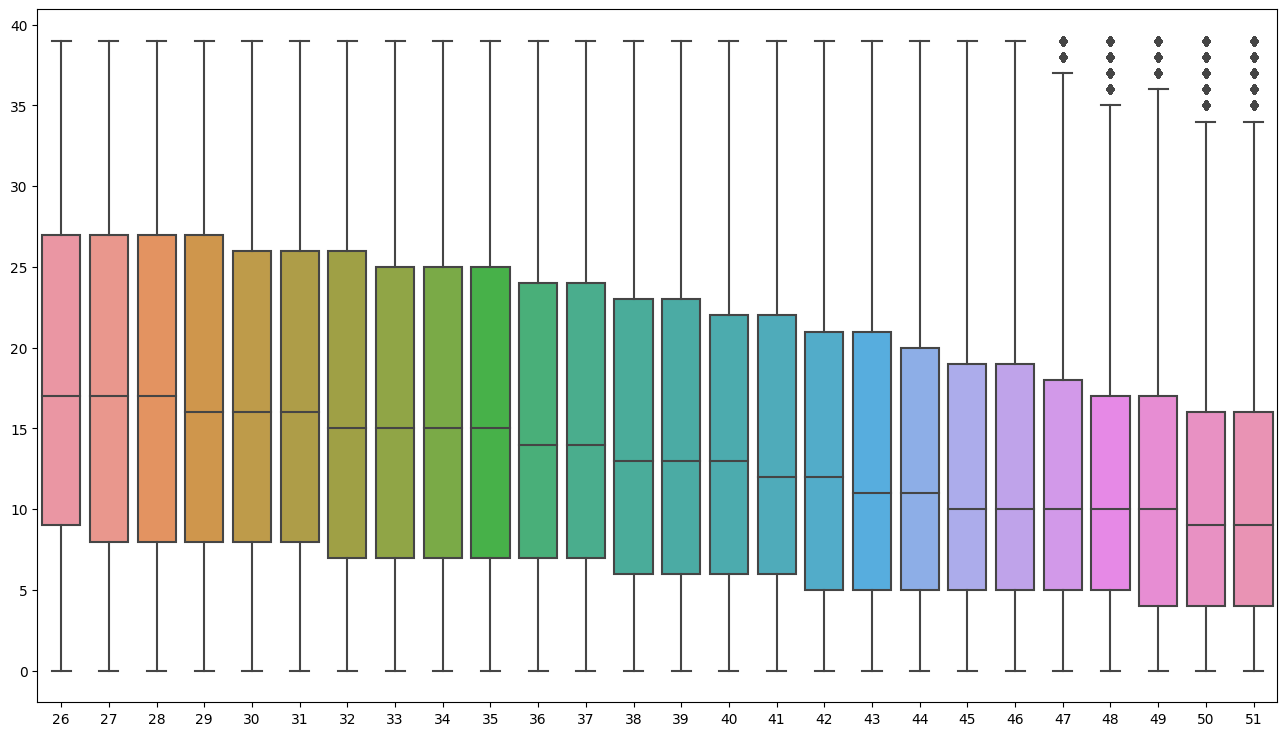

In [10]:
recs = SeqIO.parse(gzip.open(dataset_path, 'rt', encoding='utf-8'), 'fastq')
qual_pos = defaultdict(list)
for rec in recs:
    for i, qual in enumerate(rec.letter_annotations['phred_quality']):
        if i < 25 or qual == 40:
            continue
        pos = i + 1
        qual_pos[pos].append(qual)
vps = []
poses = list(qual_pos.keys())
poses.sort()
for pos in poses:
    vps.append(qual_pos[pos])
fig, ax = plt.subplots(figsize=(16,9))
sns.boxplot(data=vps, ax=ax)
ax.set_xticklabels([str(x) for x in range(26, max(qual_pos.keys()) + 1)])
pass

In this case, we will ignore both positions sequenced as 25 base pairs from the start (again, remove this rule if you have unfiltered sequencer data) and the maximum quality score for this file (40). However, in your case, you can consider starting your plotting analysis with the maximum. You may want to check the maximum possible value for your sequencer hardware. Generally, as most calls can be performed with maximum quality, you may want to remove them if you are trying to understand where quality problems lie.

# There is more...

## Do this to download the paired end data

Be careful as this will be 1GB of data (and fully optional)

In [8]:
#XXX change
!rm -f SRR003265_1.filt.fastq.gz 2>/dev/null
!rm -f SRR003265_2.filt.fastq.gz 2>/dev/null
!wget ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/phase3/data/NA18489/sequence_read/SRR003265_1.filt.fastq.gz
!wget ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/phase3/data/NA18489/sequence_read/SRR003265_2.filt.fastq.gz

--2018-08-26 16:51:39--  ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/phase3/data/NA18489/sequence_read/SRR003265_1.filt.fastq.gz
           => ‘SRR003265_1.filt.fastq.gz’
Resolving ftp.1000genomes.ebi.ac.uk (ftp.1000genomes.ebi.ac.uk)... 193.62.192.8
Connecting to ftp.1000genomes.ebi.ac.uk (ftp.1000genomes.ebi.ac.uk)|193.62.192.8|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /vol1/ftp/phase3/data/NA18489/sequence_read ... done.
==> SIZE SRR003265_1.filt.fastq.gz ... 502660639
==> PASV ... done.    ==> RETR SRR003265_1.filt.fastq.gz ... done.
Length: 502660639 (479M) (unauthoritative)

SRR003265_1.filt.fa 100%[===================>] 479.37M  18.0MB/s    in 46s     

2018-08-26 16:52:27 (10.4 MB/s) - ‘SRR003265_1.filt.fastq.gz’ saved [502660639]

--2018-08-26 16:52:27--  ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/phase3/data/NA18489/sequence_read/SRR003265_2.filt.fastq.gz
           => ‘SRR003265_2.filt.fastq.

Although it's impossible to discuss all the variations of output coming from sequencer files, paired-end reads are worth mentioning because they are common and require a different processing approach. With paired-end sequencing, both ends of a DNA fragment are sequenced with a gap in the middle (called the insert). In this case, two files will be produced: X_1.FASTQ and X_2.FASTQ. Both files will have the same order and exact same number of sequences. The first sequence will be in X_1 pairs with the first sequence of X_2, and so on. With regards to the programming technique, if you want to keep the pairing information, you might perform something like this: 

## Only do the next cell on Python 3

In [10]:
f1 = gzip.open('SRR003265_1.filt.fastq.gz', 'rt', encoding='utf8')
f2 = gzip.open('SRR003265_2.filt.fastq.gz', 'rt', encoding='utf8')
recs1 = SeqIO.parse(f1, 'fastq')
recs2 = SeqIO.parse(f2, 'fastq')
cnt = 0
for rec1, rec2 in zip(recs1, recs2):
    cnt +=1

print('Number of pairs: %d' % cnt)

Number of pairs: 9170808
